<a href="https://colab.research.google.com/github/bayu-nanda/fraud-detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Generate 1000 samples for historical data
# Import all module
import pandas as pd
import numpy as np
import random
from faker import Faker
from geopy.distance import geodesic

# Setup
fake = Faker()
np.random.seed(42)
random.seed(42)

# Definition Location and Coordinate
locations_coords = {
    "New York, USA": (40.7128, -74.0060),
    "Jakarta, ID": (-6.2088, 106.8456),
    "Singapore, SG": (1.3521, 103.8198),
    "Berlin, DE": (52.5200, 13.4050),
    "San Francisco, USA": (37.7749, -122.4194),
    "Lagos, NG": (6.5244, 3.3792),
    "Tokyo, JP": (35.6895, 139.6917),
    "Paris, FR": (48.8566, 2.3522),
    "London, UK": (51.5074, -0.1278),
    "Bangkok, TH": (13.7563, 100.5018)
}

locations = list(locations_coords.keys())
merchants = ["Amazon", "Tokopedia", "Starbucks", "Apple Store", "Alfamart", "eBay",
             "CryptoExchange", "Uniqlo", "Gojek", "Gucci"]
card_types = ["Visa", "Mastercard", "Amex"]
genders = ["Male", "Female"]

n_users = 50
n_samples = 1000
users = [f"U{i+1:03}" for i in range(n_users)]

# Create user profile (Age and Gender each user_id should be consistent)
user_profiles = {
    user_id: {
        "Age": np.random.randint(18, 70),
        "Gender": random.choice(genders)
    }
    for user_id in users
}

# Generate transaction data
data = []
for i in range(n_samples):
    user_id = random.choice(users)
    profile = user_profiles[user_id]
    timestamp = fake.date_time_between(start_date='-10d', end_date='now')
    amount = round(np.random.exponential(scale=100), 2)
    location = random.choice(locations)
    merchant = random.choice(merchants)
    card_type = random.choice(card_types)
    is_foreign = random.choices(["Yes", "No"], weights=[0.2, 0.8])[0]
    is_online = random.choices(["Yes", "No"], weights=[0.6, 0.4])[0]
    age = profile["Age"]
    gender = profile["Gender"]

    data.append([
        f"T{i+1:04}", user_id, timestamp, amount, location, merchant, card_type,
        is_foreign, is_online, age, gender,
    ])

df = pd.DataFrame(data, columns=[
    "TransactionID", "UserID", "Timestamp", "Amount", "Location", "Merchant", "CardType",
    "IsForeignTransaction", "IsOnline", "Age", "Gender"
])

df.to_csv("credit_card_transactions_1000_original.csv", index=False)
print("File saved as credit_card_transactions_1000_original.csv")

# Show 5 user_id and check whether Age and Gender is consistent or not
print(df[["UserID", "Age", "Gender"]].drop_duplicates().head())


# Add coordinate location
df["Coords"] = df["Location"].map(locations_coords)

# Create some def functions to help us more easily
def calc_distance(row):
    if pd.isna(row["PrevCoords"]):
        return 0
    return geodesic(row["Coords"], row["PrevCoords"]).km

def calc_timedelta(row):
    if pd.isna(row["PrevTime"]):
        return 9999
    return (row["Timestamp"] - row["PrevTime"]).total_seconds() / 3600  # jam

def label_fraud(row):
    high_amount = row["Amount"] > 1000
    foreign_online = row["IsForeignTransaction"] == "Yes" and row["IsOnline"] == "Yes"
    risky_merchant = row["Merchant"] == "CryptoExchange"
    very_small_amount = row["Amount"] < 2
    suspicious_jump = row["SuspiciousJump"] == 1
    big_amount_spike = (
        row["AmountDiff"] > 3 * row["AvgAmountBefore"]
        if pd.notnull(row["AvgAmountBefore"]) else False
    )

    if high_amount or foreign_online or risky_merchant or suspicious_jump or big_amount_spike:
        return 1 if random.random() < 0.7 else 0
    elif very_small_amount:
        return 1 if random.random() < 0.05 else 0
    else:
        return 0

# Calculate suspicious jump and amount diff variable
df.sort_values(by=["UserID", "Timestamp"], inplace=True)
df["PrevCoords"] = df.groupby("UserID")["Coords"].shift(1)
df["PrevTime"] = df.groupby("UserID")["Timestamp"].shift(1)
df["TravelDistanceKM"] = df.apply(calc_distance, axis=1)
df["TimeDeltaHrs"] = df.apply(calc_timedelta, axis=1)
df["SuspiciousJump"] = np.where((df["TravelDistanceKM"] > 1000) & (df["TimeDeltaHrs"] < 2), 1, 0)
df["AvgAmountBefore"] = (
    df.groupby("UserID")["Amount"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)
df["PrevAmount"] = df.groupby("UserID")["Amount"].shift(1)
df["AmountDiff"] = df["Amount"] - df["AvgAmountBefore"]
df["IsFraud"] = df.apply(label_fraud, axis=1)


df=df[["TransactionID", "UserID", "Timestamp", "Merchant","CardType",
    "IsForeignTransaction", "IsOnline","Location", "PrevTime", "TravelDistanceKM", "TimeDeltaHrs","Amount","SuspiciousJump","AvgAmountBefore","PrevAmount","AmountDiff","IsFraud"]]

# Save to CSV file
df.to_csv("credit_card_transactions_1000_clean.csv", index=False)
print("File saved as credit_card_transactions_1000_clean.csv")

# Show data summary
df[["TransactionID", "UserID", "Timestamp", "Merchant","CardType",
    "IsForeignTransaction", "IsOnline","Location", "PrevTime", "TravelDistanceKM", "TimeDeltaHrs","Amount","SuspiciousJump","AvgAmountBefore","PrevAmount","AmountDiff","IsFraud"]].head(10)



File saved as credit_card_transactions_1000_original.csv
  UserID  Age  Gender
0   U025   38  Female
1   U023   55  Female
2   U039   61  Female
3   U018   39    Male
4   U004   32    Male
File saved as credit_card_transactions_1000_clean.csv


,TransactionID,UserID,Timestamp,Merchant,CardType,IsForeignTransaction,IsOnline,Location,PrevTime,TravelDistanceKM,TimeDeltaHrs,Amount,SuspiciousJump,AvgAmountBefore,PrevAmount,AmountDiff,IsFraud
684,T0685,U001,2025-06-25 19:36:59,Tokopedia,Visa,No,No,"New York, USA",NaT,0.000000,9999.000000,13.27,0,NaN,NaN,NaN,0
383,T0384,U001,2025-06-26 00:06:56,Gucci,Visa,Yes,Yes,"Berlin, DE",2025-06-25 19:36:59,6402.432652,4.499167,39.85,0,13.270000,13.27,26.580000,1
110,T0111,U001,2025-06-26 01:23:47,Apple Store,Visa,No,Yes,"London, UK",2025-06-26 00:06:56,934.523350,1.280833,33.52,0,26.560000,39.85,6.960000,0
542,T0543,U001,2025-06-26 04:39:03,Amazon,Mastercard,No,No,"Berlin, DE",2025-06-26 01:23:47,934.523350,3.254444,15.91,0,28.880000,33.52,-12.970000,0
668,T0669,U001,2025-06-26 19:31:18,Gojek,Visa,Yes,Yes,"Lagos, NG",2025-06-26 04:39:03,5181.557345,14.870833,41.04,0,25.637500,15.91,15.402500,1
181,T0182,U001,2025-06-28 03:56:31,Gojek,Visa,No,No,"San Francisco, USA",2025-06-26 19:31:18,12571.440344,32.420278,27.08,0,28.718000,41.04,-1.638000,0
31,T0032,U001,2025-06-28 13:44:02,Apple Store,Visa,No,Yes,"Jakarta, ID",2025-06-28 03:56:31,13950.152145,9.791944,78.24,0,28.445000,27.08,49.795000,0
996,T0997,U001,2025-06-28 15:38:12,Alfamart,Visa,No,No,"Bangkok, TH",2025-06-28 13:44:02,2316.570666,1.902778,3.77,1,35.558571,78.24,-31.788571,1
76,T0077,U001,2025-06-29 13:50:51,CryptoExchange,Visa,Yes,No,"Jakarta, ID",2025-06-28 15:38:12,2316.570666,22.210833,34.21,0,31.585000,3.77,2.625000,1
69,T0070,U001,2025-06-30 22:19:04,Alfamart,Visa,No,Yes,"San Francisco, USA",2025-06-29 13:50:51,13950.152145,32.470278,71.04,0,31.876667,34.21,39.163333,0


In [ ]:
# Fraud distribution in percentage based on historical data
df["IsFraud"].value_counts(normalize=True) * 100

0    76.5
1    23.5
Name: IsFraud, dtype: float64

C:\Users\nanda\AppData\Local\Temp\ipykernel_10320\2123723802.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IsFraud", y=col, palette="Set2")


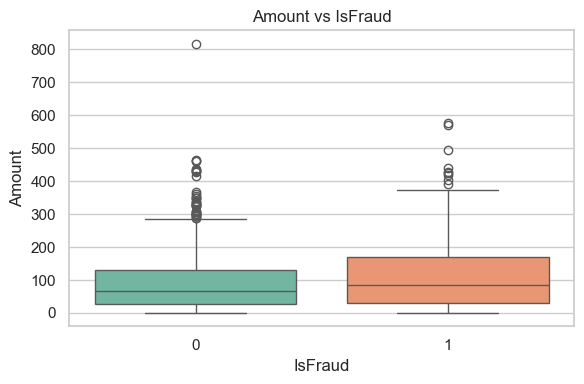

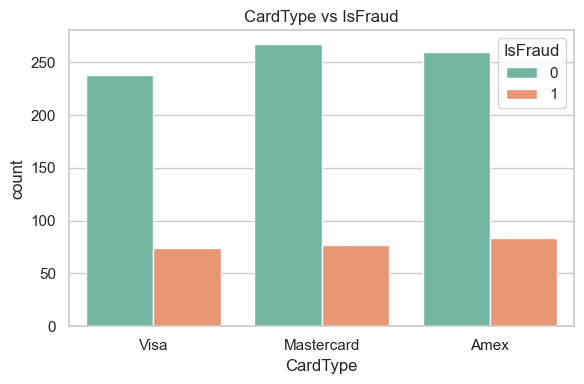

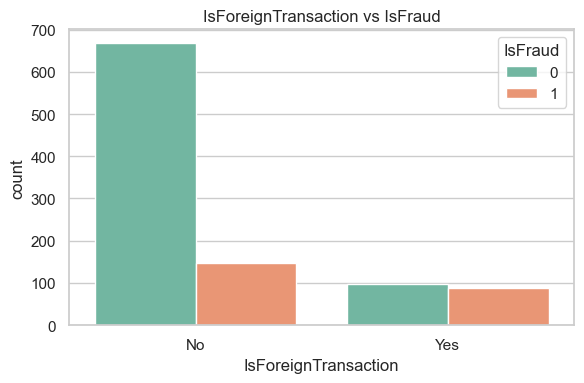

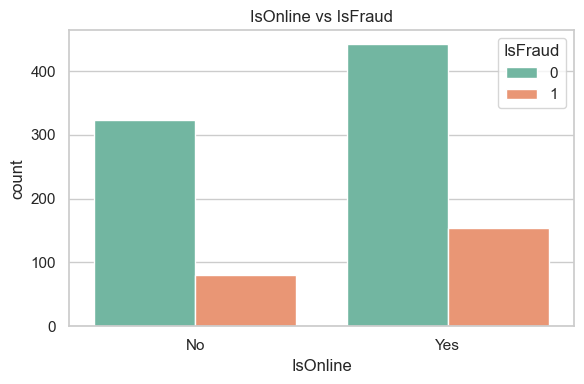

C:\Users\nanda\AppData\Local\Temp\ipykernel_10320\2123723802.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IsFraud", y=col, palette="Set2")


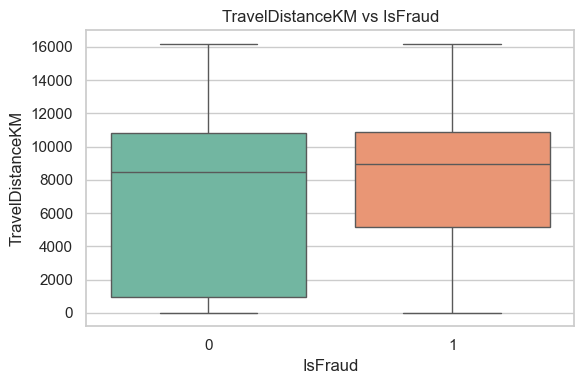

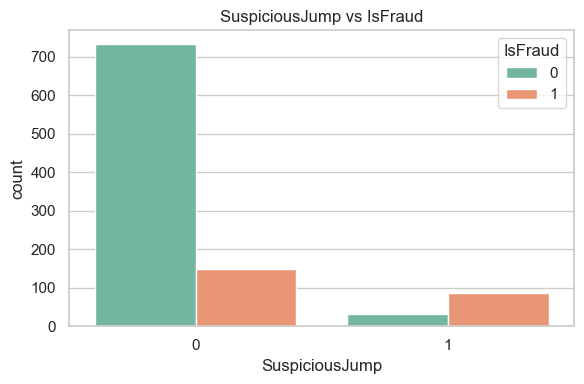

C:\Users\nanda\AppData\Local\Temp\ipykernel_10320\2123723802.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IsFraud", y=col, palette="Set2")


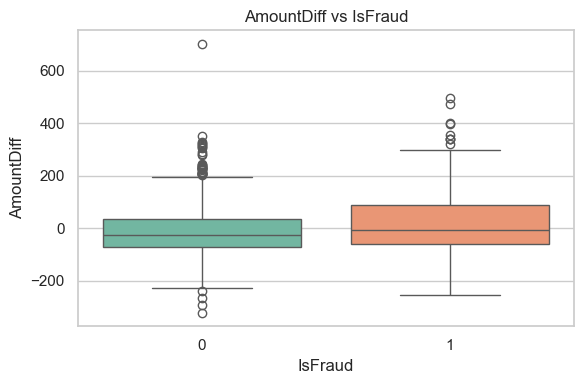

In [ ]:
# Create some plots for EDA
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style='whitegrid')

# Create a list of columns you want to analyze against 'IsFraud'
cols_to_plot = ["Amount", "CardType", "IsForeignTransaction", "IsOnline","TravelDistanceKM","SuspiciousJump","AmountDiff"]

# Plot one by one
for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    if df[col].dtype in ['int64', 'float64']:  # numerical column
        sns.boxplot(data=df, x="IsFraud", y=col, palette="Set2")
    else:  # categorical column
        sns.countplot(data=df, x=col, hue="IsFraud", palette="Set2")

    plt.title(f"{col} vs IsFraud")
    plt.tight_layout()
    plt.show()


In [ ]:
# Determine feature varibles to predict on model
features = [
    "Merchant","CardType",
    "IsForeignTransaction", "IsOnline","SuspiciousJump","Amount","AmountDiff"
]
X = df[features]
y = df["IsFraud"]


In [ ]:
# Build machine learning model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Seperate numerical and categorical variables
num_features = ["Amount", "AmountDiff"]
cat_features = ["Merchant","CardType", "IsForeignTransaction", "IsOnline","SuspiciousJump"]

# Preprocessing: Fill NaN, scaling, encoding
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")), # you can change this parameter by : mean, constant, median, dropna
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Traning and fitting your model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Pipeline Random Forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# Pipeline XGBoost
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])
xgb_pipeline.fit(X_train, y_train)


C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [17:21:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount', 'AmountDiff']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Merchant', 'CardType',
                                                   'IsForeignTransaction',
                                                   'IsOnline',
                                                   'SuspiciousJump'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Compare your models, which model has the best prediction and accuracy
from sklearn.metrics import classification_report, confusion_matrix

rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)

print("Random Forest:\n", classification_report(y_test, rf_preds))
print("XGBoost:\n", classification_report(y_test, xgb_preds))


Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       151
           1       0.69      0.73      0.71        49

    accuracy                           0.85       200
   macro avg       0.80      0.81      0.81       200
weighted avg       0.86      0.85      0.86       200

XGBoost:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       151
           1       0.71      0.76      0.73        49

    accuracy                           0.86       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.87      0.86      0.87       200



Overall for this case XGBoost is better than Random Forest model, because XGBoost has accuracy higher than random forest model

In [ ]:
# Select random value to predict data is Fraud or Legitimate
import pandas as pd

new_data = pd.DataFrame([{
    "Amount": 1500.00,
    "Merchant":"Amazon",
    "CardType": "Visa",
    "IsForeignTransaction": "Yes",
    "IsOnline": "Yes",
    "SuspiciousJump": 1,
    "AmountDiff":700
}])



# Predict using XGBoost and Random Forest
prediction_xgb = xgb_pipeline.predict(new_data)
prediction_rf = rf_pipeline.predict(new_data)

# Result
print("Model XGBoost        :","Fraud" if prediction_xgb[0] == 1 else "Legitimate")
print("Model Random Forest  :","Fraud" if prediction_rf[0] == 1 else "Legitimate")


Model XGBoost        : Fraud
Model Random Forest  : Fraud
